In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import datetime as datetime 
%matplotlib inline 

#  将 Matplotlib 绘制的图表嵌入到 Jupyter Notebook 中的输出区域，
#  并使得图表能够在代码单元格下方直接显示，而不是在新窗口中显示。

    1. 数据加载

In [2]:
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']   
plt.rcParams['axes.unicode_minus'] = False  # 用于正常显示负号    

In [3]:
#  parse_date： 将指定的列加载成 日期的格式
df= pd.read_csv('data/ccf_offline_stage1_train.csv', parse_dates=['Date_received', 'Date'])
df.info()  # 175万+ 条数据 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754884 entries, 0 to 1754883
Data columns (total 7 columns):
 #   Column         Dtype         
---  ------         -----         
 0   User_id        int64         
 1   Merchant_id    int64         
 2   Coupon_id      float64       
 3   Discount_rate  object        
 4   Distance       float64       
 5   Date_received  datetime64[ns]
 6   Date           datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 93.7+ MB


In [4]:
df.head(10)  # NaT: 时间日期格式的空值

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaT,2016-02-17
1,1439408,4663,11002.0,150:20,1.0,2016-05-28,NaT
2,1439408,2632,8591.0,20:1,0.0,2016-02-17,NaT
3,1439408,2632,1078.0,20:1,0.0,2016-03-19,NaT
4,1439408,2632,8591.0,20:1,0.0,2016-06-13,NaT
5,1439408,2632,NaN,NaN,0.0,NaT,2016-05-16
6,1439408,2632,8591.0,20:1,0.0,2016-05-16,2016-06-13
7,1832624,3381,7610.0,200:20,0.0,2016-04-29,NaT
8,2029232,3381,11951.0,200:20,1.0,2016-01-29,NaT
9,2029232,450,1532.0,30:5,0.0,2016-05-30,NaT


    2. 数据的规整

In [5]:
#  判断每一列有多少空值
df.isnull().sum()

# 优惠券id, 折扣率， 领券日期， 三者可能存在同时==null的情况 

User_id               0
Merchant_id           0
Coupon_id        701602
Discount_rate    701602
Distance         106003
Date_received    701602
Date             977900
dtype: int64

    2.1 把“Discount_rate”列中的满减政策转化成折扣率

In [6]:
df['Discount_rate'] = df['Discount_rate'].fillna('null')
df.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,null,0.0,NaT,2016-02-17
1,1439408,4663,11002.0,150:20,1.0,2016-05-28,NaT
2,1439408,2632,8591.0,20:1,0.0,2016-02-17,NaT
3,1439408,2632,1078.0,20:1,0.0,2016-03-19,NaT
4,1439408,2632,8591.0,20:1,0.0,2016-06-13,NaT


In [7]:
def discount_rate_opt(s):  # s 代表每一个元素
    if ':' in s:
        split = s.split(':')
        discount_rate = (int(split[0])-int(split[1]))/int(split[0])
        return round(discount_rate, 2)    # 折扣率保留2位小数
    elif s == 'null':
        return np.NaN
    else:
        return float(s)

In [8]:
df['Discount_rate'] = df['Discount_rate'].map(discount_rate_opt)
df.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaT,2016-02-17
1,1439408,4663,11002.0,0.87,1.0,2016-05-28,NaT
2,1439408,2632,8591.0,0.95,0.0,2016-02-17,NaT
3,1439408,2632,1078.0,0.95,0.0,2016-03-19,NaT
4,1439408,2632,8591.0,0.95,0.0,2016-06-13,NaT


    2.2 Coupon_id 字段: null 代表无优惠券， 此时 Discount_rate 与 Date_received 字段无意义

检查Coupon_id和Discount_rate与Date_received判断空值和非空值是否一一对应。

In [9]:
#  np.all(): 判断一个可迭代数据中是否都为 True, 如果是返回 True, 否则返回 False. 
a = np.all([True, True, True])
print(a)

b = np.all([True, False, True])
print(b)

True
False


In [10]:
nan1 = df['Coupon_id'].isnull()         # 判断优惠券是否为空
nan2 = df['Date_received'].isnull()     # 判断领券日期是为空
# print(nan1)
# print(nan2)

np.all(nan1 == nan2)    # 如果结果 = True, 说明之前的猜测:  Coupoun_id 与 Date_received 空值与非空值是一一对应的关系

True

In [11]:
nan3 = df['Discount_rate'].isnull()
np.all(nan1 == nan3)  # 如果结果为 True, 说明之前的猜测:  Coupoun_id 与 Discount_rate 空值与非空值是一一对应的关系

True

    2.3  分类
    
    如果 Date = null & Coupon_id != null, 有券未消费 (cpon_no_consume)
    如果 Date = null & Coupin_id = null, 无券未消费(no_cpon_no_consume)
    如果 Date != null & Coupon_id = null, 无券消费 (no_cpon_consume)
    如果 Date ！= null & Coupon_id = null, 有券消费 (cpon_consume)


In [12]:
cpon_no_consume = df[(df['Date'].isnull() & df['Coupon_id'].notnull())]
no_cpon_no_consume = df[(df['Date'].isnull() & df['Coupon_id'].isnull())]
no_cpon_consume = df[(df['Date'].notnull() & df['Coupon_id'].isnull())]
cpon_consume = df[(df['Date'].notnull() & df['Coupon_id'].notnull())]

In [13]:
print('有券未消费: {}'.format(len(cpon_no_consume)))
print('无券未消费: {}'.format(len(no_cpon_no_consume)))    # 无意义, 不需分析
print('无券消费: {}'.format(len(no_cpon_consume)))
print('有券消费: {}'.format(len(cpon_consume)))

#   用优惠券消费的用户 有 7万人, 相比其他用户来说 占比较少

有券未消费: 977900
无券未消费: 0
无券消费: 701602
有券消费: 75382


    3. 数据分析

In [14]:
#  绘制饼图
consume_status_dict = {'cpon_no_consume': len(cpon_no_consume),
                       'no_cpon_consume': len(no_cpon_consume),
                       'cpon_consume': len(cpon_consume)}
consume_status = pd.Series(consume_status_dict)

Text(0.5, 1.0, '消费占比情况')

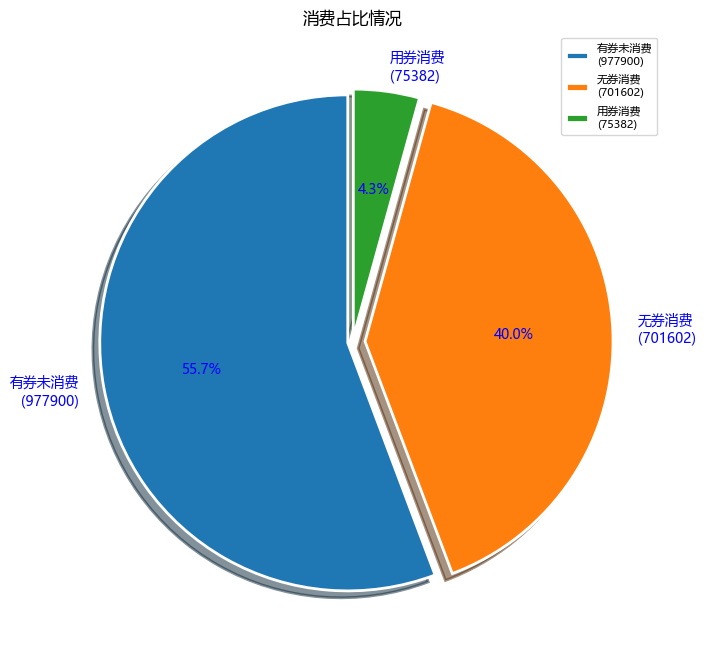

In [16]:
#  消费方式构成的饼图(figure: 画布； axes: 代表画布内的多个坐标系)
fig,ax = plt.subplots(1, 1, figsize=(8, 10))
consume_status.plot.pie(y='count',                      
                        ax=ax, 
                        autopct='%1.1f%%', 
                        shadow=True,
                        explode=[0.02, 0.05, 0.02],   # 间距
                        textprops={'fontsize': 10, 'color': 'blue'},           # 字号， 字体颜色
                        wedgeprops={'linewidth': 2, 'edgecolor': 'white'},     # 线宽， 线的颜色
                        labels=['有券未消费\n({})'.format(len(cpon_no_consume)),
                                '无券消费\n({})'.format(len(no_cpon_consume)),
                                '用券消费\n({})'.format(len(cpon_consume)),
                                ] ,    
                        startangle=90)

ax.set_ylabel('')      # 去除 ylable
plt.legend(loc='upper right', fontsize=8)
ax.set_title('消费占比情况')


#  有券未消费  占比55.7%  最大,  说明大多数人拿完券之后， 尚未使用
#  无券消费用户占比 40% , 说明很多人没有使用优惠券, 
#                       可能优惠券的吸引力不大, 顾客没在意; 
#                       也可能是, 新用户较多

#  用券消费用户占比较小 4.3%， 说明优惠券使用率不高， 可以考虑是否加大优惠券力度